In [1]:
import sys
from pathlib import Path
src_path = Path.cwd().parent / 'src'
sys.path.append(str(src_path))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Import Dependencies

This cell sets up the necessary imports used throughout the notebook. It adds the `src` directory to `sys.path` to allow local module imports, and loads common libraries such as NumPy, Pandas, and Matplotlib.


In [2]:
from data_loader import load_data

# Set up data paths
data_path = Path.cwd().parent / "data" / "ag_news"
train_path = data_path / "train.csv"
test_path = data_path / "test.csv"

# Load training data
df_train = load_data(train_path)
X_train = (df_train["Title"] + " " + df_train["Description"]).values
y_train = df_train["Class Index"].values

# Load test data
df_test = load_data(test_path)
X_test = (df_test["Title"] + " " + df_test["Description"]).values
y_test = df_test["Class Index"].values

## 2. Load Dataset

This cell loads the AG News dataset using a custom `load_data()` function from the `data_loader` module. It combines the "Title" and "Description" fields into feature arrays and extracts class labels for training and test sets.


In [3]:
from vectorizer import vectorize_data_fit
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize data
vectorizer = TfidfVectorizer()
X_train_vect = vectorize_data_fit(vectorizer, X_train)

## 3. Vectorize Text Data

Converts raw text into numerical feature vectors using a `TfidfVectorizer`. The transformation is applied to training data using a helper function from `vectorizer.py`, which wraps `fit_transform()`.


In [ ]:
from model_trainer import train_model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Train Logistic Regression Model
lr_model = LogisticRegression()
lr_trained_model = train_model(lr_model, X_train_vect, y_train)

# Train Naive Bayes Model
nb_model = MultinomialNB()
#nb_trained_model = train_model(nb_model, X_train_vect, y_train)

# Train Random Forest Model
rf_model = RandomForestClassifier()
#rf_trained_model = train_model(rf_model, X_train_vect, y_train)

## 4. Train Machine Learning Models

This step trains three different classifiers: Logistic Regression, Naive Bayes, and Random Forest. All models are trained on TF-IDF vectors using a unified `train_model()` function.


In [5]:
from perturbation import apply_perturbation

# Save perturbed data to file
X_data = X_test[:1000]
level = 0.4 # Perturbation level (0.0 to 1.0)
augmentation_type = "wordnet" # Choose from: "wordnet", "charswap", "deletion"
create_file = False

if create_file:
    perturbed_data = apply_perturbation(
        X_data,
        level,
        save_path=f"perturbed_data/ag_news/{augmentation_type}/perturbed_data_{level:.2f}.pkl"
    )

c:\Users\t440p\miniconda3\envs\thesis-py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 5. Apply Perturbations to Text Data

We apply adversarial perturbations to a subset of test data using `textattack` augmenters (e.g., WordNet, character swaps, deletions). The perturbed data is saved to disk to avoid repeated computation.

> ⚠️ This step can be slow. You can control whether to (re)generate data by toggling the `create_file` flag.


In [ ]:
from evaluator import evaluate_robustness

# Evaluation pipeline

# Number of samples to evaluate
X_sample = X_test[:1000]
y_sample = y_test[:1000]

# Define perturbation levels to test, always include 0.0 (original data)
perturbation_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Add required metrics to evaluate
metrics = ["rs", "mce", "pdr", "mds"]

# Set the file path for perturbed data
augmentation_type = "wordnet" # Choose from: "wordnet", "charswap", "deletion"

# Use filepath when using pertrubed data from files for faster testing
file_path = Path(f"perturbed_data/ag_news/{augmentation_type}")

# Add model to evaluate (also used for plotting)
model = lr_trained_model # Choose from: lg_trained_model, nb_trained_model, rf_trained_model

results = evaluate_robustness(
    model,
    vectorizer,
    X_sample, 
    y_sample,
    perturbation_levels,
    metrics,
    file_path,
    augmentation_type
)

results_df = pd.DataFrame(results)
print("*** Results Per Perturbation Level")
display(results_df)


*** Results Per Perturbation Level


,perturbation level,accuracy,RS,mCE,PDR,MDS
0,0.0,0.907,NaN,NaN,NaN,NaN
1,0.1,0.903,0.996,0.097,0.004,NaN
2,0.2,0.883,0.974,0.107,0.026,0.400
3,0.3,0.867,0.956,0.116,0.044,0.320
4,0.4,0.859,0.947,0.122,0.053,0.160
5,0.5,0.858,0.946,0.126,0.054,0.020
6,0.6,0.836,0.922,0.132,0.078,0.440
7,0.7,0.831,0.916,0.138,0.084,0.100
8,0.8,0.829,0.914,0.142,0.086,0.040
9,0.9,0.803,0.885,0.148,0.115,0.520


## 6. Evaluate Model Robustness

This cell evaluates the model's performance under different perturbation levels. Metrics such as accuracy, robustness score (RS), mean corruption error (mCe), performance drop rate (PDR) and mean divergence score (MDS) are computed using perturbed data loaded from disk.

The results are compiled into a dataframe.


In [ ]:
# Save results to csv file

augmentation_type = "wordnet" # Choose from: "wordnet", "charswap", "deletion"
model_name = "lr" # Choose from: "lr", "nb", "rf"
save_file = False

if save_file:
    results_df.to_csv(Path(f"results/ag_news/{augmentation_type}/{model_name}.csv"), index=False)



## 7. Save Results to CSV File

This cell exports the evaluation results to a CSV file, making it easy to persist the output of the robustness analysis.

The saved file can be used for further analysis and visualizations — such as tables, plots, or comparative studies — in external tools or later stages of this notebook. 

Each row in the CSV corresponds to a specific perturbation level, along with the associated accuracy and robustness metrics (e.g., RS, mCE, PDR, MDS), depending on the metrics selected during evaluation.


In [7]:
from data_loader import load_data
# Load csv files

#CHARSWAP
df_chars_lr = load_data(Path("results/ag_news/charswap/lr.csv"))
df_chars_nb = load_data(Path("results/ag_news/charswap/nb.csv"))
df_chars_rf = load_data(Path("results/ag_news/charswap/rf.csv"))

#DELETION
df_del_lr = load_data(Path("results/ag_news/deletion/lr.csv"))
df_del_nb = load_data(Path("results/ag_news/deletion/nb.csv"))
df_del_rf = load_data(Path("results/ag_news/deletion/rf.csv"))

#WORDNET
df_word_lr = load_data(Path("results/ag_news/wordnet/lr.csv"))
df_word_nb = load_data(Path("results/ag_news/wordnet/nb.csv"))
df_word_rf = load_data(Path("results/ag_news/wordnet/rf.csv"))

## 8. Load Evaluation Results

This cell loads previously saved evaluation results from CSV files using the `load_data` utility function. Each CSV file corresponds to a specific model (`lr`, `nb`, `rf`) and perturbation type (`charswap`, `deletion`, `wordnet`) evaluated on the AG News dataset.

These loaded DataFrames can now be used for comparison, aggregation, or visualization of model robustness under different perturbation strategies.

PLOTTING RESULTS

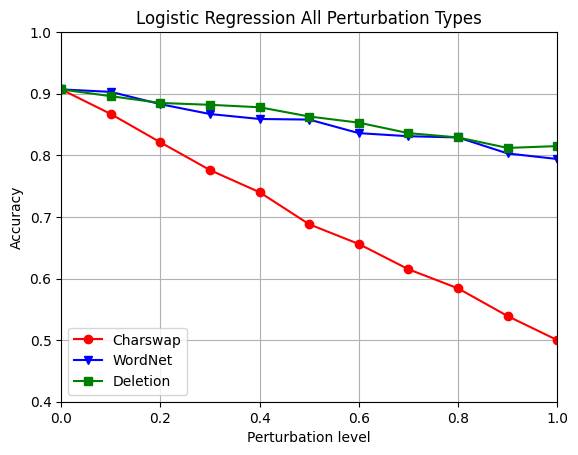

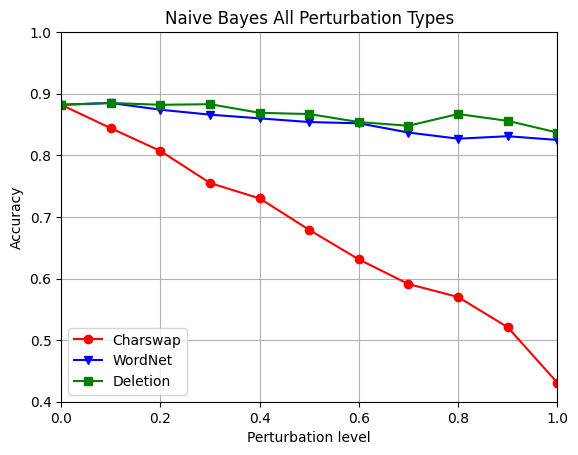

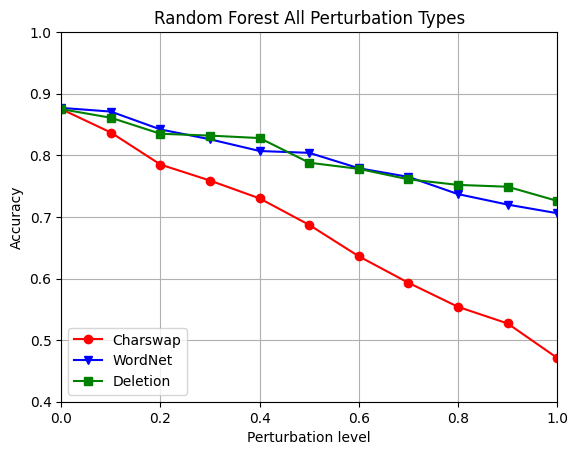

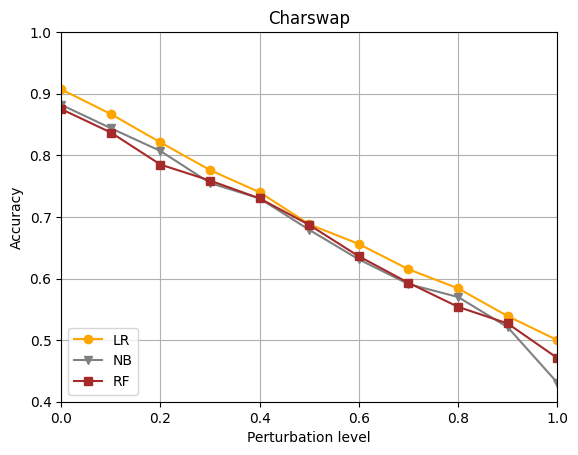

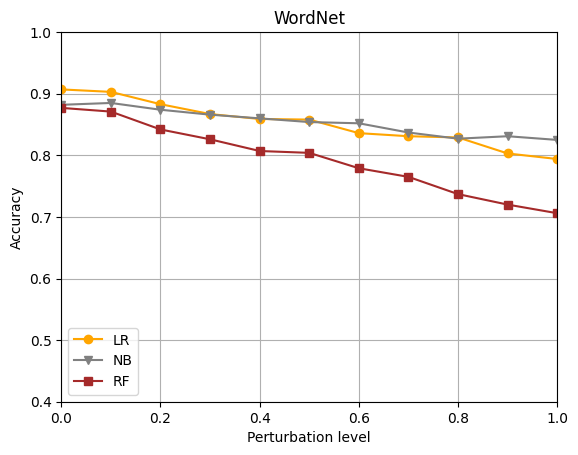

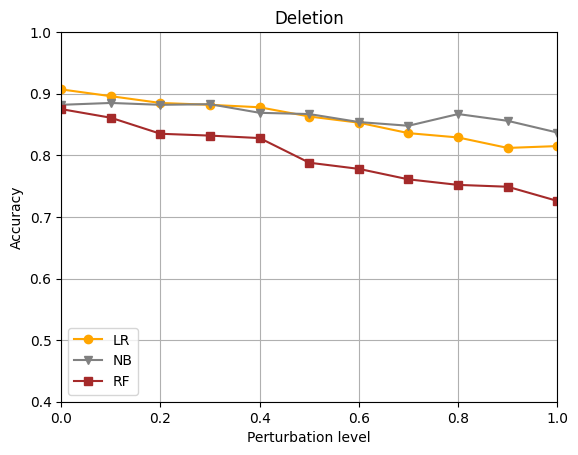

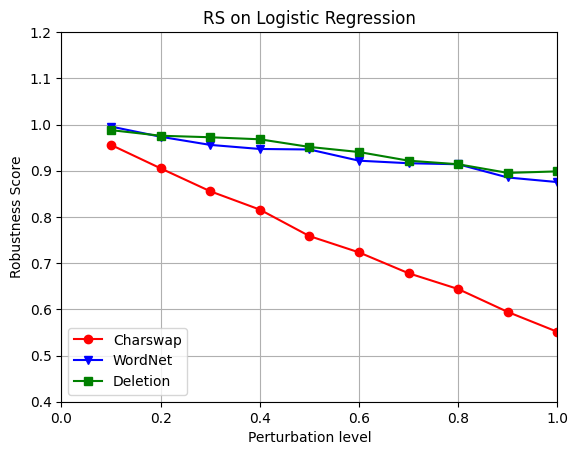

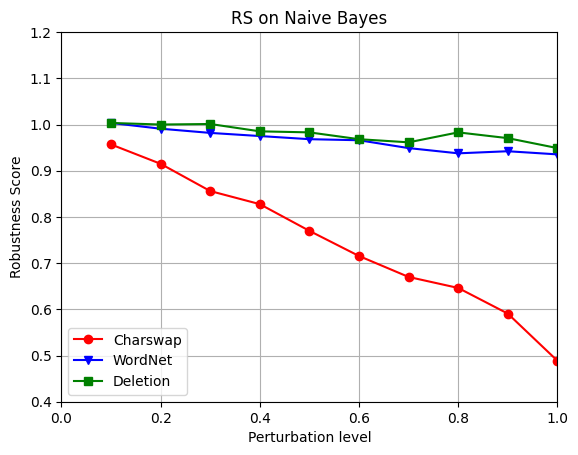

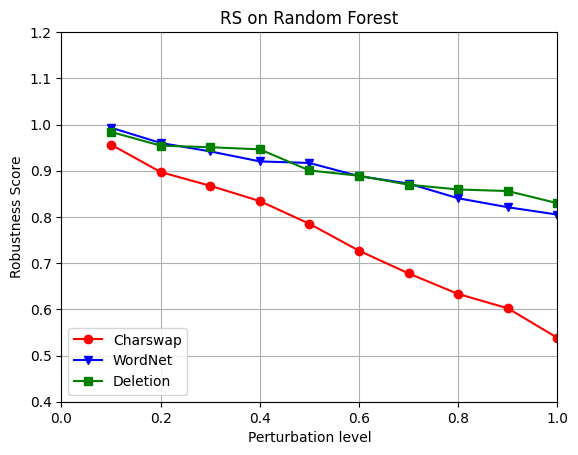

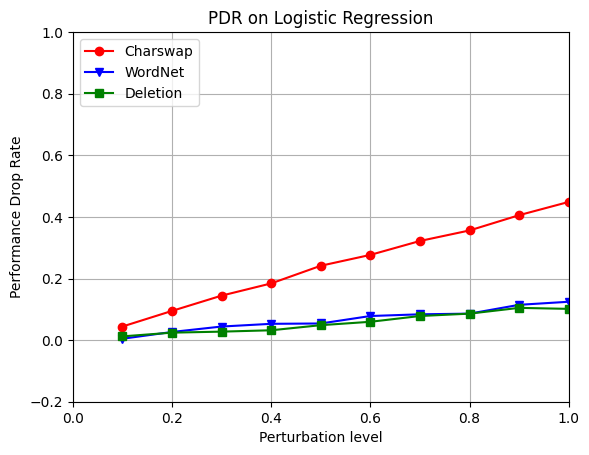

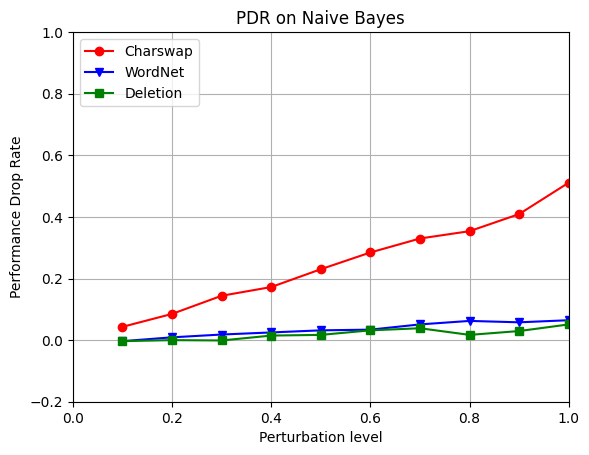

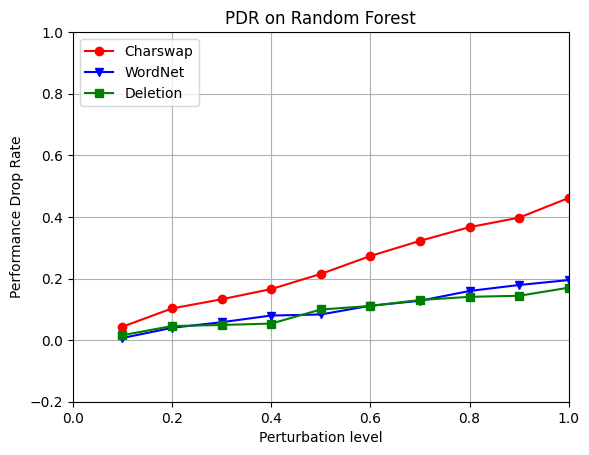

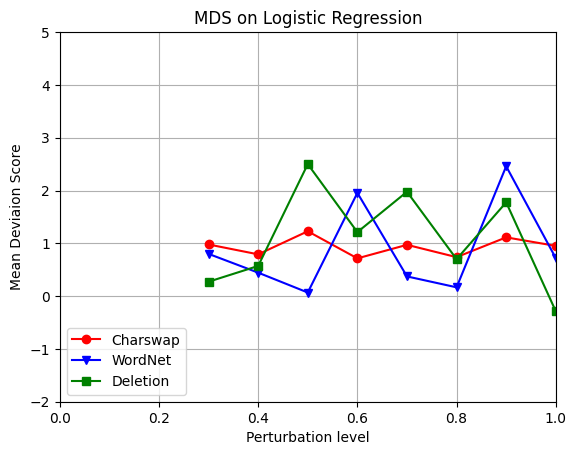

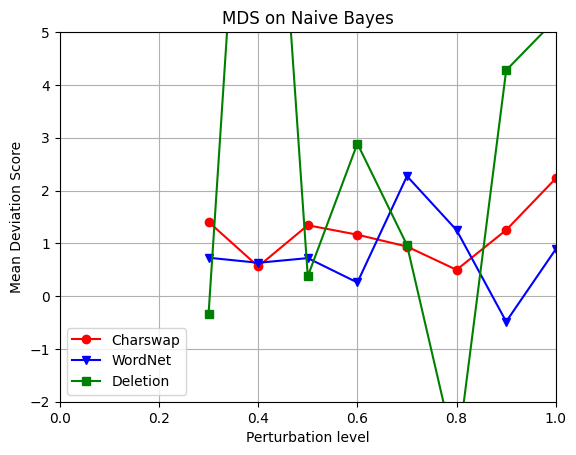

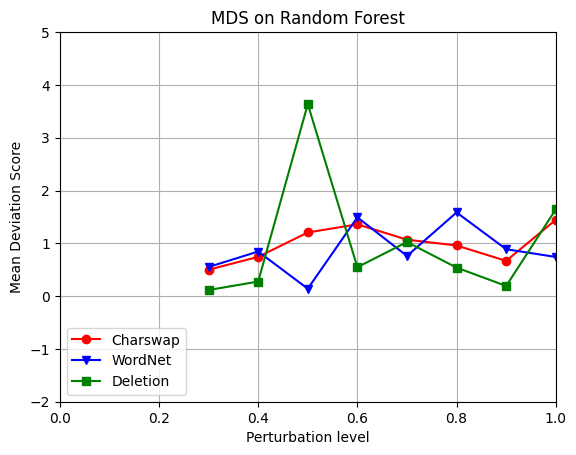

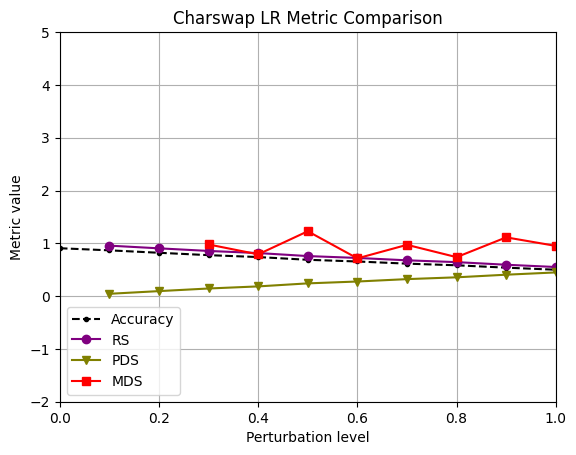

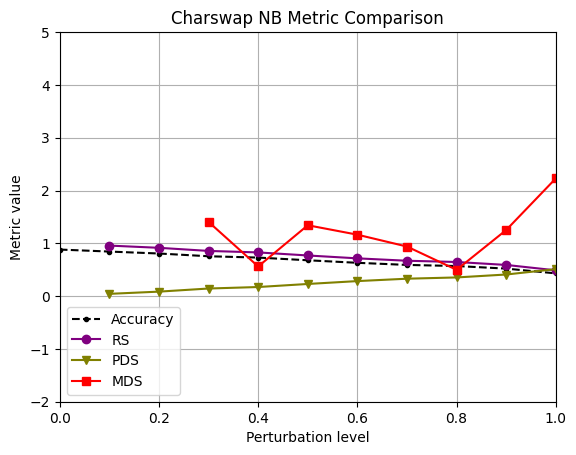

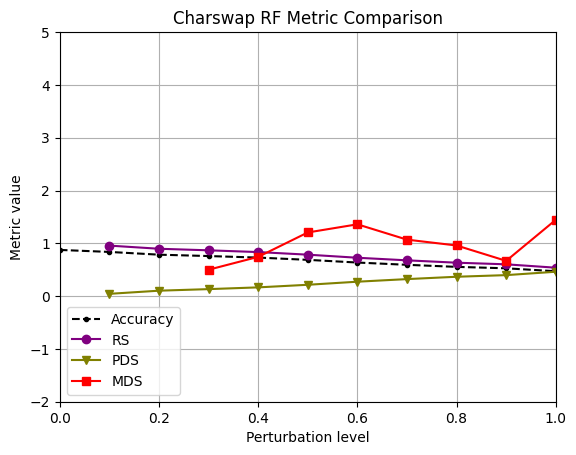

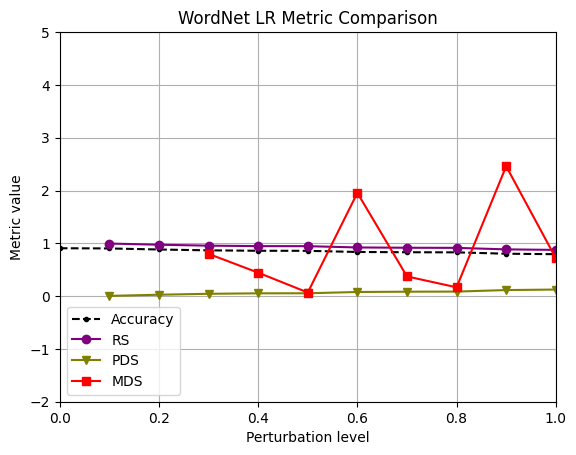

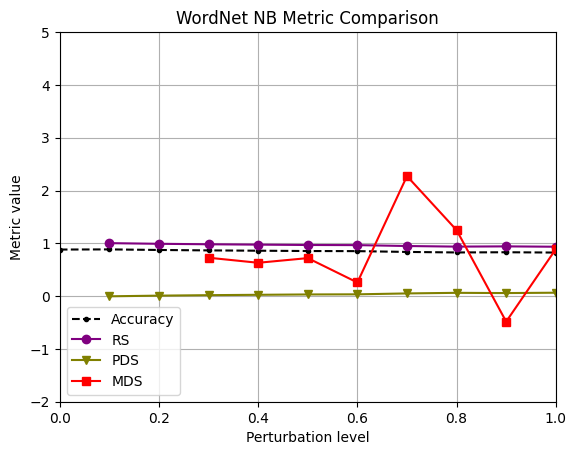

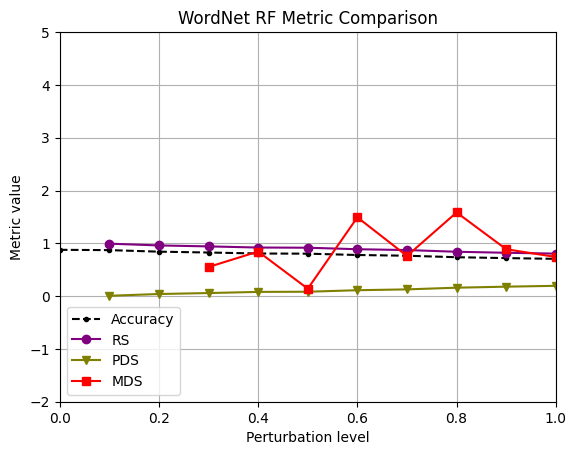

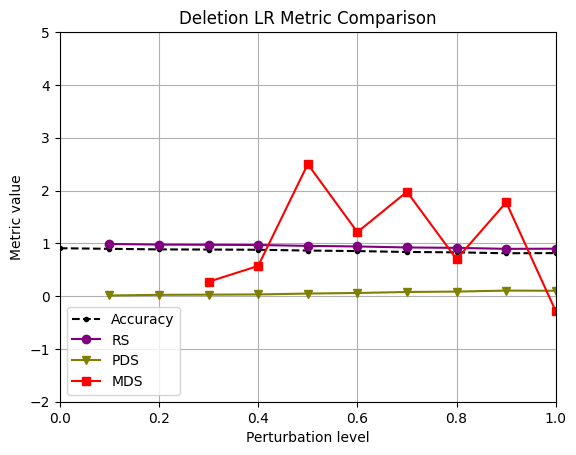

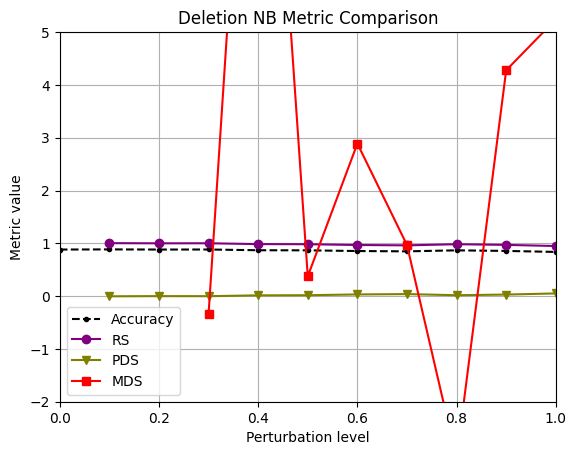

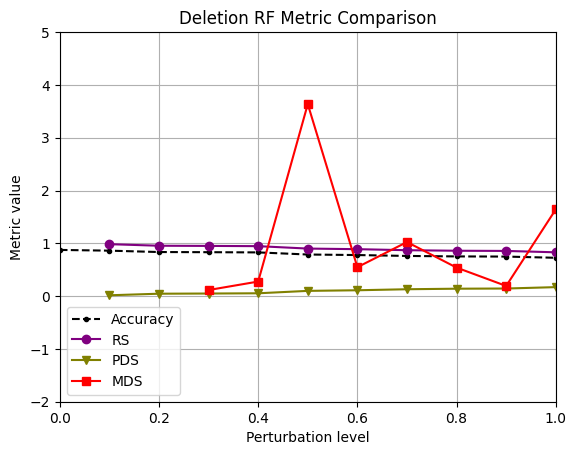

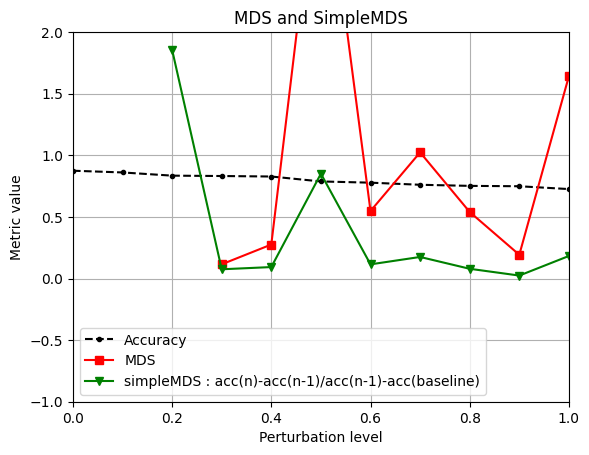

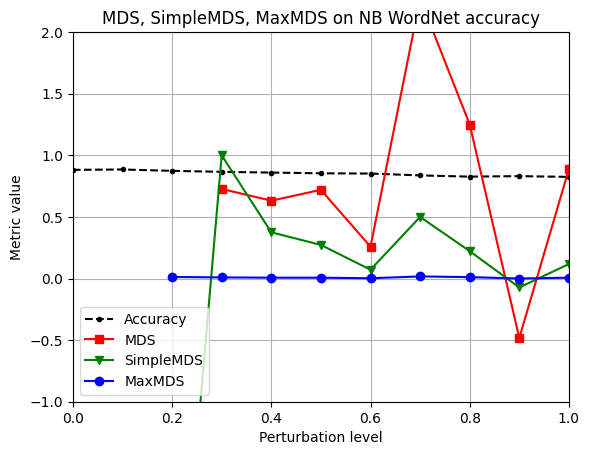

In [8]:


# SUBSETS TO PLOT

# LR all accuracy/perturbation
plt.plot(df_chars_lr["perturbation level"], df_chars_lr["accuracy"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_lr["perturbation level"], df_word_lr["accuracy"], marker="v", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_lr["perturbation level"], df_del_lr["accuracy"], marker="s", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Accuracy")
plt.title("Logistic Regression All Perturbation Types")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(0.4, 1)
plt.grid()
plt.show()


# NB all accuracy/perturbation
plt.plot(df_chars_nb["perturbation level"], df_chars_nb["accuracy"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_nb["perturbation level"], df_word_nb["accuracy"], marker="v", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_nb["perturbation level"], df_del_nb["accuracy"], marker="s", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Accuracy")
plt.title("Naive Bayes All Perturbation Types")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(0.4, 1)
plt.grid()
plt.show()

# RF all
plt.plot(df_chars_rf["perturbation level"], df_chars_rf["accuracy"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_rf["perturbation level"], df_word_rf["accuracy"], marker="v", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_rf["perturbation level"], df_del_rf["accuracy"], marker="s", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Accuracy")
plt.title("Random Forest All Perturbation Types")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(0.4, 1)
plt.grid()
plt.show()


# CHARSWAP
plt.plot(df_chars_lr["perturbation level"], df_chars_lr["accuracy"], marker="o", linestyle= "-", color="orange", label="LR")
plt.plot(df_chars_nb["perturbation level"], df_chars_nb["accuracy"], marker="v", linestyle= "-", color="gray", label="NB")
plt.plot(df_chars_rf["perturbation level"], df_chars_rf["accuracy"], marker="s", linestyle= "-", color="brown", label="RF")
plt.xlabel("Perturbation level")
plt.ylabel("Accuracy")
plt.title("Charswap")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(0.4, 1)
plt.grid()
plt.show()

# WORDNET
plt.plot(df_word_lr["perturbation level"], df_word_lr["accuracy"], marker="o", linestyle= "-", color="orange", label="LR")
plt.plot(df_word_nb["perturbation level"], df_word_nb["accuracy"], marker="v", linestyle= "-", color="gray", label="NB")
plt.plot(df_word_rf["perturbation level"], df_word_rf["accuracy"], marker="s", linestyle= "-", color="brown", label="RF")
plt.xlabel("Perturbation level")
plt.ylabel("Accuracy")
plt.title("WordNet")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(0.4, 1)
plt.grid()
plt.show()

# DELETION
plt.plot(df_del_lr["perturbation level"], df_del_lr["accuracy"], marker="o", linestyle= "-", color="orange", label="LR")
plt.plot(df_del_nb["perturbation level"], df_del_nb["accuracy"], marker="v", linestyle= "-", color="gray", label="NB")
plt.plot(df_del_rf["perturbation level"], df_del_rf["accuracy"], marker="s", linestyle= "-", color="brown", label="RF")
plt.xlabel("Perturbation level")
plt.ylabel("Accuracy")
plt.title("Deletion")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(0.4, 1)
plt.grid()
plt.show()


# METRICS
# ROBUSTNESS SCORE ALL LR
plt.plot(df_chars_lr["perturbation level"], df_chars_lr["RS"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_lr["perturbation level"], df_word_lr["RS"], marker="v", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_lr["perturbation level"], df_del_lr["RS"], marker="s", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Robustness Score")
plt.title("RS on Logistic Regression")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(0.4, 1.2)
plt.grid()
plt.show()


# ROBUSTNESS SCORE ALL NB
plt.plot(df_chars_nb["perturbation level"], df_chars_nb["RS"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_nb["perturbation level"], df_word_nb["RS"], marker="v", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_nb["perturbation level"], df_del_nb["RS"], marker="s", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Robustness Score")
plt.title("RS on Naive Bayes")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(0.4, 1.2)
plt.grid()
plt.show()

# ROBUSTNESS SCORE ALL RF
plt.plot(df_chars_rf["perturbation level"], df_chars_rf["RS"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_rf["perturbation level"], df_word_rf["RS"], marker="v", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_rf["perturbation level"], df_del_rf["RS"], marker="s", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Robustness Score")
plt.title("RS on Random Forest")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(0.4, 1.2)
plt.grid()
plt.show()

# PDR ALL LR
plt.plot(df_chars_lr["perturbation level"], df_chars_lr["PDR"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_lr["perturbation level"], df_word_lr["PDR"], marker="v", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_lr["perturbation level"], df_del_lr["PDR"], marker="s", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Performance Drop Rate")
plt.title("PDR on Logistic Regression")
plt.legend(loc="upper left")
plt.xlim(0, 1)
plt.ylim(-0.2, 1)
plt.grid()
plt.show()


# PDR ALL NB
plt.plot(df_chars_nb["perturbation level"], df_chars_nb["PDR"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_nb["perturbation level"], df_word_nb["PDR"], marker="v", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_nb["perturbation level"], df_del_nb["PDR"], marker="s", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Performance Drop Rate")
plt.title("PDR on Naive Bayes")
plt.legend(loc="upper left")
plt.xlim(0, 1)
plt.ylim(-0.2, 1)
plt.grid()
plt.show()

# PDR ALL RF
plt.plot(df_chars_rf["perturbation level"], df_chars_rf["PDR"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_rf["perturbation level"], df_word_rf["PDR"], marker="v", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_rf["perturbation level"], df_del_rf["PDR"], marker="s", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Performance Drop Rate")
plt.title("PDR on Random Forest")
plt.legend(loc="upper left")
plt.xlim(0, 1)
plt.ylim(-0.2, 1)
plt.grid()
plt.show()

# MDS ALL LR
plt.plot(df_chars_lr["perturbation level"], df_chars_lr["MDS"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_lr["perturbation level"], df_word_lr["MDS"], marker="v", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_lr["perturbation level"], df_del_lr["MDS"], marker="s", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Mean Deviaion Score")
plt.title("MDS on Logistic Regression")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(-2, 5)
plt.grid()
plt.show()


# MDS ALL NB
plt.plot(df_chars_nb["perturbation level"], df_chars_nb["MDS"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_nb["perturbation level"], df_word_nb["MDS"], marker="v", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_nb["perturbation level"], df_del_nb["MDS"], marker="s", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Mean Deviation Score")
plt.title("MDS on Naive Bayes")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(-2, 5)
plt.grid()
plt.show()

# MDS ALL RF
plt.plot(df_chars_rf["perturbation level"], df_chars_rf["MDS"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_rf["perturbation level"], df_word_rf["MDS"], marker="v", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_rf["perturbation level"], df_del_rf["MDS"], marker="s", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Mean Deviation Score")
plt.title("MDS on Random Forest")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(-2, 5)
plt.grid()
plt.show()


# METRICS ON EACH PERTURBATION TYPE COMPARED TO ACCURACY FOR EACH MODEL
# CHARSWAP LOGISTIC REGRESSION
plt.plot(df_chars_lr["perturbation level"], df_chars_lr["accuracy"], marker=".", linestyle= "--", color="black", label="Accuracy")
plt.plot(df_chars_lr["perturbation level"], df_chars_lr["RS"], marker="o", linestyle= "-", color="purple", label="RS")
plt.plot(df_chars_lr["perturbation level"], df_chars_lr["PDR"], marker="v", linestyle= "-", color="olive", label="PDS")
plt.plot(df_chars_lr["perturbation level"], df_chars_lr["MDS"], marker="s", linestyle= "-", color="red", label="MDS")

plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("Charswap LR Metric Comparison")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(-2, 5)
plt.grid()
plt.show()

# CHARSWAP NAIVE BAYES
plt.plot(df_chars_nb["perturbation level"], df_chars_nb["accuracy"], marker=".", linestyle= "--", color="black", label="Accuracy")
plt.plot(df_chars_nb["perturbation level"], df_chars_nb["RS"], marker="o", linestyle= "-", color="purple", label="RS")
plt.plot(df_chars_nb["perturbation level"], df_chars_nb["PDR"], marker="v", linestyle= "-", color="olive", label="PDS")
plt.plot(df_chars_nb["perturbation level"], df_chars_nb["MDS"], marker="s", linestyle= "-", color="red", label="MDS")

plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("Charswap NB Metric Comparison")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(-2, 5)
plt.grid()
plt.show()

# CHARSWAP RANDOM FOREST
plt.plot(df_chars_rf["perturbation level"], df_chars_rf["accuracy"], marker=".", linestyle= "--", color="black", label="Accuracy")
plt.plot(df_chars_rf["perturbation level"], df_chars_rf["RS"], marker="o", linestyle= "-", color="purple", label="RS")
plt.plot(df_chars_rf["perturbation level"], df_chars_rf["PDR"], marker="v", linestyle= "-", color="olive", label="PDS")
plt.plot(df_chars_rf["perturbation level"], df_chars_rf["MDS"], marker="s", linestyle= "-", color="red", label="MDS")

plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("Charswap RF Metric Comparison")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(-2, 5)
plt.grid()
plt.show()


# WORDNET LOGISTIC REGRESSION
plt.plot(df_word_lr["perturbation level"], df_word_lr["accuracy"], marker=".", linestyle= "--", color="black", label="Accuracy")
plt.plot(df_word_lr["perturbation level"], df_word_lr["RS"], marker="o", linestyle= "-", color="purple", label="RS")
plt.plot(df_word_lr["perturbation level"], df_word_lr["PDR"], marker="v", linestyle= "-", color="olive", label="PDS")
plt.plot(df_word_lr["perturbation level"], df_word_lr["MDS"], marker="s", linestyle= "-", color="red", label="MDS")

plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("WordNet LR Metric Comparison")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(-2, 5)
plt.grid()
plt.show()

# WORDNET NAIVE BAYES
plt.plot(df_word_nb["perturbation level"], df_word_nb["accuracy"], marker=".", linestyle= "--", color="black", label="Accuracy")
plt.plot(df_word_nb["perturbation level"], df_word_nb["RS"], marker="o", linestyle= "-", color="purple", label="RS")
plt.plot(df_word_nb["perturbation level"], df_word_nb["PDR"], marker="v", linestyle= "-", color="olive", label="PDS")
plt.plot(df_word_nb["perturbation level"], df_word_nb["MDS"], marker="s", linestyle= "-", color="red", label="MDS")

plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("WordNet NB Metric Comparison")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(-2, 5)
plt.grid()
plt.show()

# WORDNET RANDOM FOREST
plt.plot(df_word_rf["perturbation level"], df_word_rf["accuracy"], marker=".", linestyle= "--", color="black", label="Accuracy")
plt.plot(df_word_rf["perturbation level"], df_word_rf["RS"], marker="o", linestyle= "-", color="purple", label="RS")
plt.plot(df_word_rf["perturbation level"], df_word_rf["PDR"], marker="v", linestyle= "-", color="olive", label="PDS")
plt.plot(df_word_rf["perturbation level"], df_word_rf["MDS"], marker="s", linestyle= "-", color="red", label="MDS")

plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("WordNet RF Metric Comparison")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(-2, 5)
plt.grid()
plt.show()

# DELETION LOGISTIC REGRESSION
plt.plot(df_del_lr["perturbation level"], df_del_lr["accuracy"], marker=".", linestyle= "--", color="black", label="Accuracy")
plt.plot(df_del_lr["perturbation level"], df_del_lr["RS"], marker="o", linestyle= "-", color="purple", label="RS")
plt.plot(df_del_lr["perturbation level"], df_del_lr["PDR"], marker="v", linestyle= "-", color="olive", label="PDS")
plt.plot(df_del_lr["perturbation level"], df_del_lr["MDS"], marker="s", linestyle= "-", color="red" \
"", label="MDS")

plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("Deletion LR Metric Comparison")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(-2, 5)
plt.grid()
plt.show()

# DELETION NAIVE BAYES
plt.plot(df_del_nb["perturbation level"], df_del_nb["accuracy"], marker=".", linestyle= "--", color="black", label="Accuracy")
plt.plot(df_del_nb["perturbation level"], df_del_nb["RS"], marker="o", linestyle= "-", color="purple", label="RS")
plt.plot(df_del_nb["perturbation level"], df_del_nb["PDR"], marker="v", linestyle= "-", color="olive", label="PDS")
plt.plot(df_del_nb["perturbation level"], df_del_nb["MDS"], marker="s", linestyle= "-", color="red", label="MDS")

plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("Deletion NB Metric Comparison")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(-2, 5)
plt.grid()
plt.show()

# DELETION RANDOM FOREST
plt.plot(df_del_rf["perturbation level"], df_del_rf["accuracy"], marker=".", linestyle= "--", color="black", label="Accuracy")
plt.plot(df_del_rf["perturbation level"], df_del_rf["RS"], marker="o", linestyle= "-", color="purple", label="RS")
plt.plot(df_del_rf["perturbation level"], df_del_rf["PDR"], marker="v", linestyle= "-", color="olive", label="PDS")
plt.plot(df_del_rf["perturbation level"], df_del_rf["MDS"], marker="s", linestyle= "-", color="red", label="MDS")

plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("Deletion RF Metric Comparison")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(-2, 5)
plt.grid()
plt.show()



# TESTING SimpleMDS DELETION RANDOM FOREST
plt.plot(df_del_rf["perturbation level"], df_del_rf["accuracy"], marker=".", linestyle= "--", color="black", label="Accuracy")
plt.plot(df_del_rf["perturbation level"], df_del_rf["MDS"], marker="s", linestyle= "-", color="red", label="MDS")
plt.plot(df_del_rf["perturbation level"], np.array([None, None, 1.857, 0.075, 0.093, 0.851, 0.115, 0.175, 0.079, 0.024, 0.183]), marker="v", linestyle= "-", color="green", label="simpleMDS : acc(n)-acc(n-1)/acc(n-1)-acc(baseline)")
plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("MDS and SimpleMDS")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(-1, 2)
plt.grid()
plt.show()


# Comparing MDS, SimpleMDS and MaxMDS on WordNet Naive Bayes
plt.plot(df_word_nb["perturbation level"], df_word_nb["accuracy"], marker=".", linestyle= "--", color="black", label="Accuracy")
plt.plot(df_word_nb["perturbation level"], df_word_nb["MDS"], marker="s", linestyle= "-", color="red", label="MDS")
plt.plot(df_word_nb["perturbation level"], df_word_nb["SimpleMDS"], marker="v", linestyle= "-", color="green", label="SimpleMDS")
plt.plot(df_word_nb["perturbation level"], df_word_nb["MaxMDS"], marker="o", linestyle= "-", color="blue", label="MaxMDS")
plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("MDS, SimpleMDS, MaxMDS on NB WordNet accuracy")
plt.legend(loc="lower left")
plt.xlim(0, 1)
plt.ylim(-1, 2)
plt.grid()
plt.show()